# Lab 2

## Task 04: ConvNet, Part 03: Learning Decay

In [1]:
import tensorflow as tf        
# to visualize the resutls
import matplotlib.pyplot as plt 
# 70k mnist dataset that comes with the tensorflow container
from tensorflow.examples.tutorials.mnist import input_data      

tf.set_random_seed(0)   

In [2]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, strides):
    return tf.nn.conv2d(x, W, strides=strides, padding='SAME')

In [3]:
                                        
# load data, 60K trainset and 10K testset
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)  

# 1. Define Variables and Placeholders


X = tf.placeholder(tf.float32, [None, 784])
Y_ = tf.placeholder(tf.float32, [None, 10])
XX = tf.reshape(X, [-1, 28, 28, 1])

# 2. Define the model

# Stride of 2 reduces WxH by 2?

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.003
lr = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100000, 0.96, staircase=False)

# we get one vector from one conv layer, and pass it to the next one to transform it
W1 = tf.Variable(tf.truncated_normal([5, 5, 1, 4], stddev=0.1))
B1 = tf.Variable(tf.zeros([4]))
W1CONV = tf.nn.relu(conv2d(XX, W1, strides=[1,1,1,1]) + B1)
# W1CONV = conv2d(X, W1, strides=[1,1,1,1]) + B1


W2 = tf.Variable(tf.truncated_normal([5, 5, 4, 8], stddev=0.1))
B2 = tf.Variable(tf.zeros([8]))
W2CONV = tf.nn.relu(conv2d(W1CONV, W2, strides=[1,2,2,1]) + B2)
# W2CONV = conv2d(W1CONV, W2, strides=[1,2,2,1]) + B2


W3 = tf.Variable(tf.truncated_normal([4, 4, 8, 12], stddev=0.1))
B3 = tf.Variable(tf.zeros([12]))
W3CONV = tf.nn.relu(conv2d(W2CONV, W3, strides=[1,2,2,1]) + B3)
# W3CONV = conv2d(W2CONV, W3, strides=[1,2,2,1]) + B3

# print W1CONV.get_shape()
# print W2CONV.get_shape()
# print W3CONV.get_shape()

W4 = weight_variable([7 * 7 * 12, 200])
B4 = tf.Variable(tf.zeros([200]))
W4FC = tf.nn.relu(tf.matmul(tf.reshape(W3CONV, [-1, 7 * 7 * 12]), W4) + B4)

W5 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
B5 = tf.Variable(tf.zeros([10]))

Ylogits = tf.nn.relu(tf.matmul(W4FC, W5) + B5)
Y = tf.nn.softmax(Ylogits)

# B2 = tf.Variable(tf.zeros([100]))
# W3 = tf.Variable(tf.truncated_normal([100, 60], stddev=0.1))
# B3 = tf.Variable(tf.zeros([60]))
# W4 = tf.Variable(tf.truncated_normal([60, 30], stddev=0.1))
# B4 = tf.Variable(tf.zeros([30]))
# W5 = tf.Variable(tf.truncated_normal([30, 10], stddev=0.1))
# B5 = tf.Variable(tf.zeros([10]))
                 
                 
# XX = tf.reshape(X, [-1, 784])
# Y1 = tf.nn.relu(tf.matmul(XX, W1) + B1)
# Y1D = tf.nn.dropout(Y1, pkeep)
# Y2 = tf.nn.relu(tf.matmul(Y1D, W2) + B2)
# Y2D = tf.nn.dropout(Y2, pkeep)
# Y3 = tf.nn.relu(tf.matmul(Y2D, W3) + B3)
# Y3D = tf.nn.dropout(Y3, pkeep)
# Y4 = tf.nn.relu(tf.matmul(Y3D, W4) + B4)
# Y4D = tf.nn.dropout(Y4, pkeep)
# Ylogits = tf.nn.relu(tf.matmul(Y4D, W5) + B5)
# Y = tf.nn.softmax(Ylogits)

# # 3. Define the loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(Y, Y_))

# # 4. Define the accuracy 
accuracy = tf.Variable(tf.zeros([1], tf.float32))
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# # 5. Define an optimizer
# train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy, global_step=global_step)
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy, global_step=global_step)

# # initialize
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)


def training_step(i, update_test_data, update_train_data):

    print "\r", i,
    ####### actual learning 
    # reading batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    
    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y})
    
    ####### evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    train_a = []
    train_c = []
    test_a = []
    test_c = []
    if update_train_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y})
        train_a.append(a)
        train_c.append(c)

    if update_test_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels})
        test_a.append(a)
        test_c.append(c)

    
    return (train_a, train_c, test_a, test_c)


# 6. Train and test the model, store the accuracy and loss per iteration

train_a = []
train_c = []
test_a = []
test_c = []
    
training_iter = 10000
epoch_size = 100
for i in range(training_iter):
    test = False
    if i % epoch_size == 0:
        test = True
    a, c, ta, tc = training_step(i, test, test)
    train_a += a
    train_c += c
    test_a += ta
    test_c += tc


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
9999


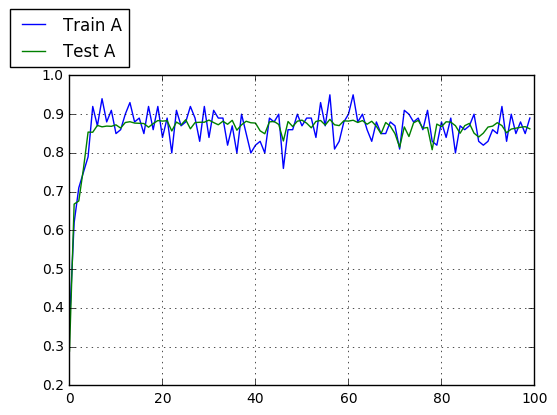

In [4]:
# 7. Plot and visualise the accuracy and loss

# accuracy training vs testing dataset
plt.plot(train_a, label="Train A")
plt.plot(test_a, label="Test A")
plt.grid(True)
plt.legend(bbox_to_anchor=(0, 1), loc='lower center', ncol=1)
plt.show()


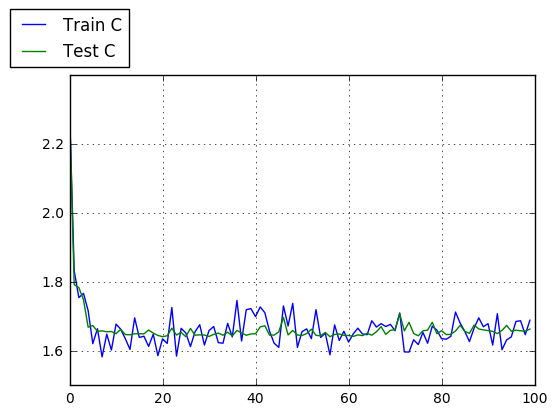

In [5]:
# loss training vs testing dataset
plt.plot(train_c, label="Train C")
plt.plot(test_c, label="Test C")
plt.grid(True)
plt.legend(bbox_to_anchor=(0, 1), loc='lower center', ncol=1)
plt.show()


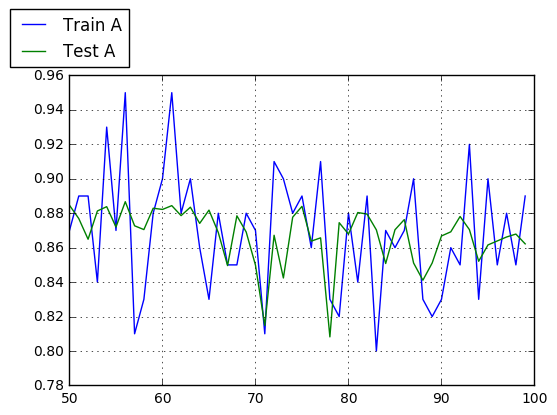

In [6]:
# Zoom in on the tail of the plots
zoom_point = 50
x_range = range(zoom_point,training_iter/epoch_size)
plt.plot(x_range, train_a[zoom_point:], label="Train A")
plt.plot(x_range, test_a[zoom_point:], label="Test A")
plt.grid(True)
plt.legend(bbox_to_anchor=(0, 1), loc='lower center', ncol=1)
plt.show()

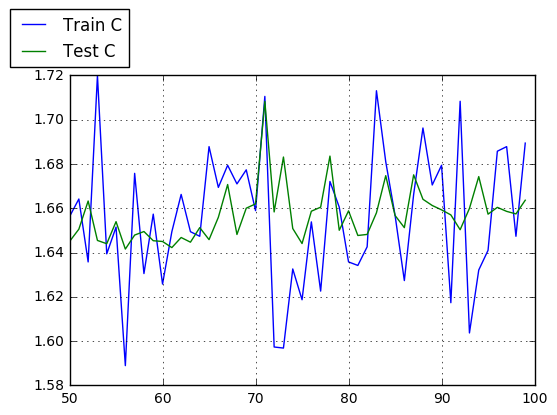

In [7]:
plt.plot(x_range, train_c[zoom_point:], label="Train C")
plt.plot(x_range, test_c[zoom_point:], label="Test C")
plt.grid(True)
plt.legend(bbox_to_anchor=(0, 1), loc='lower center', ncol=1)
plt.show()

In [8]:
a, c = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels})
print "Accuracy: %f, Loss: %f" %(a, c)

Accuracy: 0.866600, Loss: 1.660430


In [9]:
sess.close()

Minor improvement. Model still seems to have bias